Dominant Wave Direction: 112.50 degrees


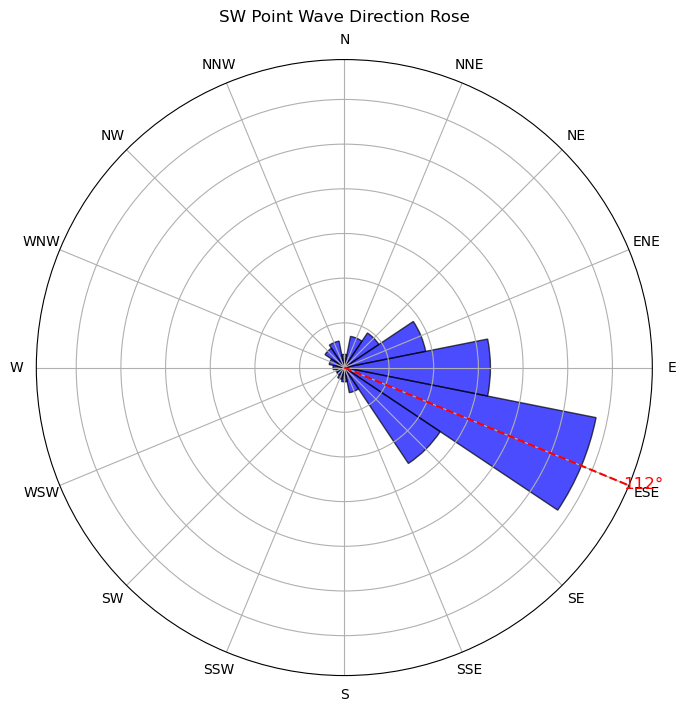

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the CSV file
# Assuming the CSV file has columns 'valid_time', 'waved'
data = pd.read_csv(r'C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\WaveData\SSW point\waveswind_SSWpoint.csv', parse_dates=['valid_time'])

# Extract the wave direction data
wave_directions = data['waved']

# Define the number of bins and bin width (22.5-degree bins)
num_bins = 16  # 16 bins for 22.5-degree width
bin_width = 360 / num_bins  # Calculate the width of each bin (22.5 degrees)

# Define bin centers and edges
bin_centers = np.arange(0, 360, bin_width)  # Bin centers: 0, 22.5, 45, ..., 337.5
bin_edges = np.arange(-bin_width / 2, 360 + bin_width / 2, bin_width)  # Edges span ±11.25° around centers

# Calculate histogram with the adjusted bin edges
hist, _ = np.histogram(wave_directions, bins=bin_edges, range=(0, 360))

# Identify the dominant wave direction
dominant_wave_direction_index = np.argmax(hist)
dominant_wave_direction = bin_centers[dominant_wave_direction_index]

# Output dominant direction
print(f"Dominant Wave Direction: {dominant_wave_direction:.2f} degrees")

# Convert bin centers to radians for plotting
angles = np.radians(bin_centers)
radii = hist

# Create polar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
bars = ax.bar(angles, radii, width=np.radians(bin_width), color='blue', alpha=0.7, edgecolor='black')

# Highlight dominant wave direction
dominant_wave_angle = np.radians(dominant_wave_direction)
ax.axvline(dominant_wave_angle, color='red', linestyle='--', label='Dominant Wave Direction')

# Customize compass layout
ax.set_title('SW Point Wave Direction Rose', va='bottom')

# Set tick positions and labels for compass orientation
compass_labels = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
compass_angles = np.radians(bin_centers)  # Center ticks at bin centers
ax.set_xticks(compass_angles)
ax.set_xticklabels(compass_labels)

# Set the angle offset so that North is at the top (0°)
ax.set_theta_offset(np.pi / 2)

# Set theta direction to clockwise
ax.set_theta_direction(-1)

# Extend radial limit slightly for dominant direction label
outer_radius = np.max(hist) * 1.2  # Extend radius slightly for better label visibility
ax.set_ylim(0, outer_radius)

# Add dominant direction label on outer perimeter
ax.text(dominant_wave_angle, outer_radius * 1.05, f'{int(dominant_wave_direction)}°', 
        ha='center', va='bottom', fontsize=12, color='red')

# Remove radial tick labels
ax.set_yticklabels([])

# Save and show the plot
plt.savefig(r"C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\Memo_Figures\SSW_Waved.png", format="png", dpi=300, bbox_inches="tight")
plt.show()


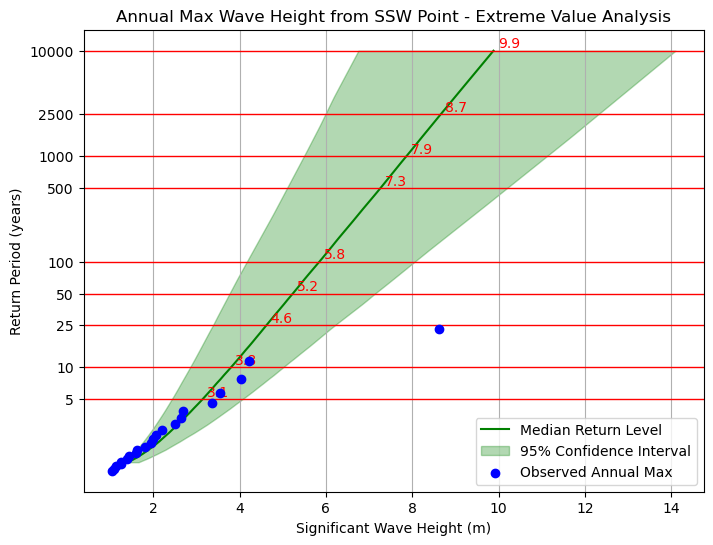

   Return Period (years)  Median Return Level Wind Speed (m/s)  \
0                      5                              3.148895   
1                     10                              3.804468   
2                     25                              4.622604   
3                     50                              5.234028   
4                    100                              5.847288   
5                    500                              7.265020   
6                   1000                              7.862493   
7                   2500                              8.658403   
8                  10000                              9.879713   

   Lower 90% CI (m/s)  Upper 90% CI (m/s)  Associated Wave Period (s)  
0            2.433196            4.071534                    7.942010  
1            2.855976            5.010433                    8.445173  
2            3.384918            6.207984                    9.073105  
3            3.768466            7.137548          

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gumbel_r
from scipy import stats
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv(r'C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\WaveData\Duck Key\SSW point\waveswind_SSWpoint.csv')
data['valid_time'] = pd.to_datetime(data['valid_time'])
# Filter for directional bin
directional_bin = (data['waved'] >= 146.25) & (data['waved'] <= 168.75)
filtered_data = data[directional_bin].copy()

# Extract year and group by it
filtered_data['year'] = filtered_data['valid_time'].dt.year

# Calculate observed annual maximum 
annual_max = filtered_data.groupby('year').agg(
    max_hsig=('hsig', 'max')
).reset_index()

# Define return periods for the analysis
return_periods_full = np.logspace(0.1, 4, 100)  # 1 to 10,000 years
n_bootstraps = 1000

# Create an array to store return levels for each bootstrap
bootstrap_return_levels = np.zeros((n_bootstraps, len(return_periods_full)))

# Bootstrapping from the observed annual maxima
for i in range(n_bootstraps):
    # Resample observed annual maxima with replacement
    resampled_annual_max = annual_max['max_hsig'].sample(frac=1, replace=True)
    
    # Fit Gumbel distribution to the resampled data
    params = gumbel_r.fit(resampled_annual_max)
    
    # Calculate return levels for the given return periods
    bootstrap_return_levels[i, :] = gumbel_r.ppf(1 - 1/return_periods_full, *params)

# Calculate 5th percentile (lower bound), 50th percentile (median), and 95th percentile (upper bound)
confidence_intervals_full = np.percentile(bootstrap_return_levels, [5, 50, 95], axis=0)
lower_90_confidence = confidence_intervals_full[0, :]  # 5th percentile
median_return_levels = confidence_intervals_full[1, :]  # Median (50th percentile)
upper_90_confidence = confidence_intervals_full[2, :]  # 95th percentile

# Define specific return periods for summary table and labels
highlighted_return_periods = [5, 10, 25, 50, 100, 500, 1000, 2500, 10000]
highlighted_speed_levels = np.interp(
    highlighted_return_periods,
    return_periods_full,
    median_return_levels
)

# Linear regression function for waves > 3.5 meters
def associate_peak_periods(hsig_levels):
    valid_data = filtered_data[['hsig', 'pp1d']].dropna()

    # Filter for significant wave heights greater than 3 meters
    valid_data_above_3m = valid_data[valid_data['hsig'] > 3.5]

    # Perform linear regression on the valid data (hsig vs pp1d) for waves > 3 meters
    slope, intercept, r_value, p_value, std_err = stats.linregress(valid_data_above_3m['hsig'], valid_data_above_3m['pp1d'])

    # Generate the associated peak periods using the linear regression model
    associated_periods = slope * hsig_levels + intercept
    return associated_periods

# Calculate associated periods for the median return levels
associated_periods_median = associate_peak_periods(median_return_levels)

highlighted_ci_5 = np.interp(highlighted_return_periods, return_periods_full, lower_90_confidence)
highlighted_ci_95 = np.interp(highlighted_return_periods, return_periods_full, upper_90_confidence)
highlighted_median_levels = np.interp(highlighted_return_periods, return_periods_full, median_return_levels)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(median_return_levels, return_periods_full, 'g-', label='Median Return Level')
plt.fill_betweenx(return_periods_full, 
                  lower_90_confidence, upper_90_confidence, 
                  color='green', alpha=0.3, label='95% Confidence Interval')

# Add horizontal lines for specified return periods with interpolated hsig levels as labels
for i, period in enumerate(highlighted_return_periods):
    plt.axhline(y=period, color='red', linestyle='-', linewidth=1)
    plt.text(highlighted_speed_levels[i] + 0.1, period, f"{highlighted_speed_levels[i]:.1f}", 
             color='red', verticalalignment='bottom')

# Calculate return periods for observed annual maxima
annual_max_sorted = annual_max.sort_values(by='max_hsig', ascending=False).reset_index(drop=True)
n_maxima = len(annual_max_sorted)
annual_max_sorted['rank'] = np.arange(1, n_maxima + 1)
annual_max_sorted['return_period'] = (n_maxima + 1) / annual_max_sorted['rank']

# Plot the observed annual maxima on the correct return period
plt.scatter(annual_max_sorted['max_hsig'], annual_max_sorted['return_period'], 
            color='blue', label='Observed Annual Max', zorder=5)

# Set y-axis to log scale and apply custom ticks for the y-axis
plt.yscale('log')
plt.yticks(highlighted_return_periods, [str(p) for p in highlighted_return_periods])

# Remove minor ticks on y-axis
plt.gca().yaxis.set_minor_locator(plt.NullLocator())

# Labels and title
plt.xlabel('Significant Wave Height (m)')
plt.ylabel('Return Period (years)')
plt.title('Annual Max Wave Height from SSW Point - Extreme Value Analysis')
plt.legend()
plt.grid(True, which="both", axis="x")

plt.savefig(r"C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\Memo_Figures\SSW_Wave_return_levels.png", format="png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

# Create a summary DataFrame with return levels and confidence intervals
results = pd.DataFrame({
    'Return Period (years)': highlighted_return_periods,
    'Median Return Level Wind Speed (m/s)': highlighted_speed_levels,
    'Lower 90% CI (m/s)': highlighted_ci_5,
    'Upper 90% CI (m/s)': highlighted_ci_95,
    'Associated Wave Period (s)': associate_peak_periods(highlighted_median_levels)
})

# Output the results
print(results)

# Save the results DataFrame to an Excel file
output_file = r"C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\Memo_Figures\SSW_Wave_return_levels.xlsx"
results.to_excel(output_file, index=False)

print(f"Results have been saved to: {output_file}")

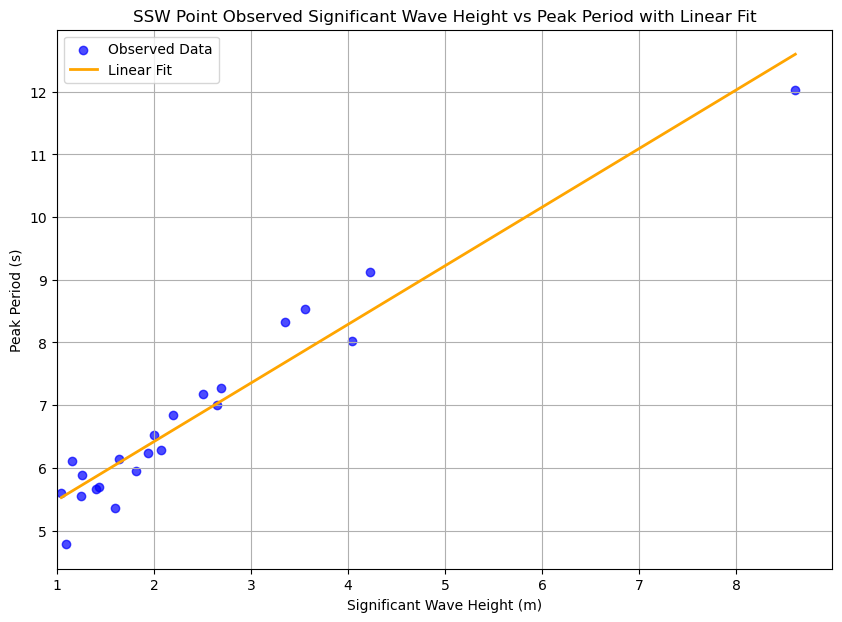

Linear Fit Equation: Peak Period (s) = 0.93 * Hs (m) + 4.55
R-squared value: 0.94


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv(r'C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\WaveData\SSW point\waveswind_SSWpoint.csv')
data['valid_time'] = pd.to_datetime(data['valid_time'])

# Filter for directional bin
directional_bin = (data['waved'] >= 146.25) & (data['waved'] <= 168.75)
filtered_data = data[directional_bin].copy()

# Extract year and group by it
filtered_data['year'] = filtered_data['valid_time'].dt.year

# Calculate observed annual maximum (hsig and pp1d together)
annual_max = filtered_data.loc[
    filtered_data.groupby('year')['hsig'].idxmax()
].reset_index(drop=True)

# Filter for significant wave heights greater than 0 meters
valid_data_above_3m = annual_max[annual_max['hsig'] > 0][['hsig', 'pp1d']].dropna()

# Linear regression: hsig vs pp1d for waves > 3.5 meters
slope, intercept, r_value, p_value, std_err = stats.linregress(
    valid_data_above_3m['hsig'], valid_data_above_3m['pp1d']
)

# Generate a range of hsig values for plotting the trend line
hsig_values = np.linspace(valid_data_above_3m['hsig'].min(), valid_data_above_3m['hsig'].max(), 100)
predicted_periods = slope * hsig_values + intercept

# Plotting the observed data points
plt.figure(figsize=(10, 7))
plt.scatter(valid_data_above_3m['hsig'], valid_data_above_3m['pp1d'], alpha=0.7, label='Observed Data', color='blue')

# Plotting the linear fit (trend line)
plt.plot(hsig_values, predicted_periods, color='orange', label='Linear Fit', linewidth=2)

# Labels and title
plt.xlabel('Significant Wave Height (m)')
plt.ylabel('Peak Period (s)')
plt.title('SSW Point Observed Significant Wave Height vs Peak Period with Linear Fit')

# Set x-axis to start at 1 meters
plt.xlim(left=1)

# Show legend
plt.legend()

# Show grid
plt.grid(True)

# Show the plot
plt.savefig(r"C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\Memo_Figures\SSW_PPD.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

# Output the linear regression results
print(f"Linear Fit Equation: Peak Period (s) = {slope:.2f} * Hs (m) + {intercept:.2f}")
print(f"R-squared value: {r_value**2:.2f}")

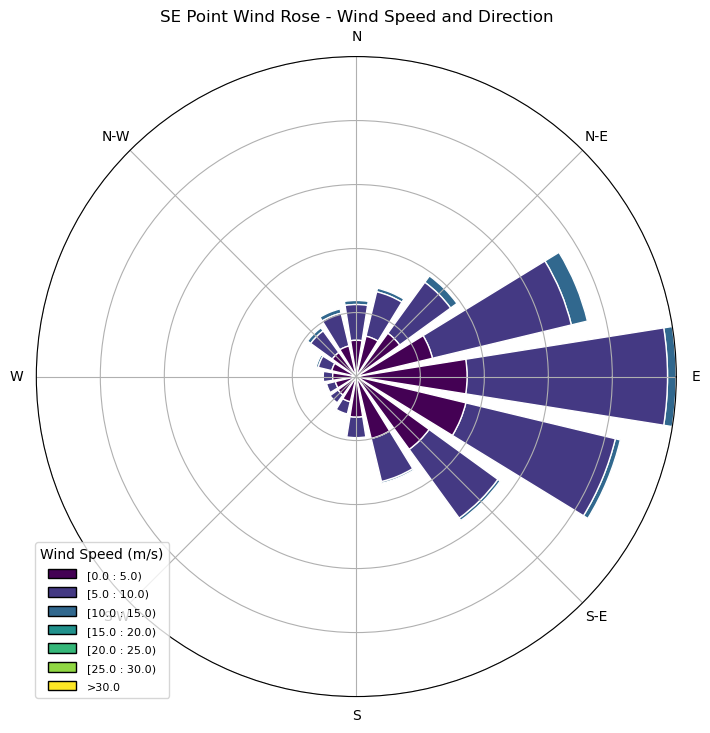

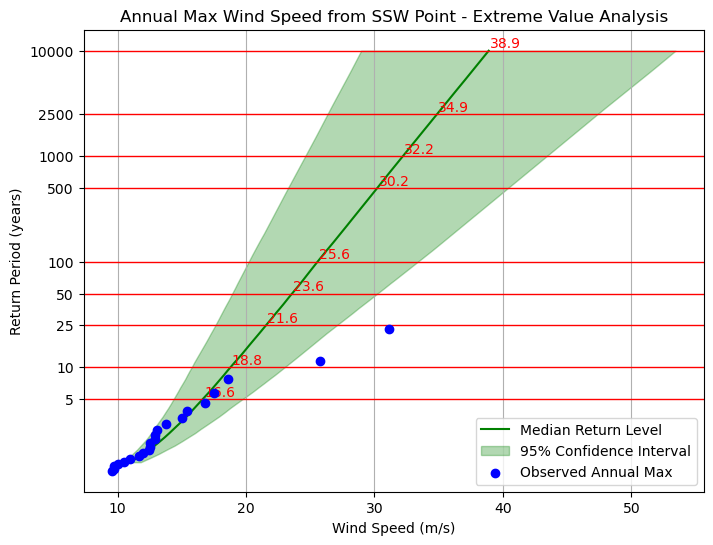

   Return Period (years)  Median Return Level Wind Speed (m/s)  \
0                      5                             16.630707   
1                     10                             18.786456   
2                     25                             21.552887   
3                     50                             23.582031   
4                    100                             25.562012   
5                    500                             30.217332   
6                   1000                             32.203120   
7                   2500                             34.862053   
8                  10000                             38.892806   

   Lower 90% CI (m/s)  Upper 90% CI (m/s)  
0           14.355090           19.732663  
1           15.761321           22.998196  
2           17.606442           27.064628  
3           18.915799           30.225120  
4           20.196118           33.368452  
5           23.264545           40.396797  
6           24.595407          

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import gumbel_r
import matplotlib.pyplot as plt
from windrose import WindroseAxes

# Load the data
data = pd.read_csv(r'C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\WaveData\Duck Key\SSW point\waveswind_SSWpoint.csv')

# Convert 'valid_time' to datetime if necessary
data['valid_time'] = pd.to_datetime(data['valid_time'])

# Plot a wind rose for the original data
fig = plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax(fig=fig)
ax.bar(data['windd'], data['windsp'], normed=True, opening=0.8, edgecolor='white', bins=np.arange(0, data['windsp'].max() + 1, 5))
ax.set_legend(title="Wind Speed (m/s)")
plt.title('SE Point Wind Rose - Wind Speed and Direction')
ax.yaxis.set_tick_params(labelleft=False, labelright=False)
plt.show()

# Filter for directional bin (ENE)
directional_bin = (data['windd'] >= 146.25) & (data['windd'] <= 168.75)
filtered_data = data[directional_bin].copy()

# Extract year and group by it
filtered_data['year'] = filtered_data['valid_time'].dt.year

# Calculate observed annual maximum wind speeds
annual_max = filtered_data.groupby('year').agg(
    max_wind_speed=('windsp', 'max')
).reset_index()

# Define return periods for the analysis
return_periods_full = np.logspace(0.1, 4, 100)  # 1 to 10,000 years
n_bootstraps = 1000

# Create an array to store return levels for each bootstrap
bootstrap_return_levels = np.zeros((n_bootstraps, len(return_periods_full)))

# Bootstrapping from the observed annual maxima
for i in range(n_bootstraps):
    # Resample observed annual maxima with replacement
    resampled_annual_max = annual_max['max_wind_speed'].sample(frac=1, replace=True)
    
    # Fit Gumbel distribution to the resampled data
    params = gumbel_r.fit(resampled_annual_max)
    
    # Calculate return levels for the given return periods
    bootstrap_return_levels[i, :] = gumbel_r.ppf(1 - 1/return_periods_full, *params)

# Calculate 5th percentile (lower bound), 50th percentile (median), and 95th percentile (upper bound)
confidence_intervals_full = np.percentile(bootstrap_return_levels, [5, 50, 95], axis=0)
lower_90_confidence = confidence_intervals_full[0, :]  # 5th percentile
median_return_levels = confidence_intervals_full[1, :]  # Median (50th percentile)
upper_90_confidence = confidence_intervals_full[2, :]  # 95th percentile

# Define specific return periods for summary table and labels
highlighted_return_periods = [5, 10, 25, 50, 100, 500, 1000, 2500, 10000]
highlighted_speed_levels = np.interp(
    highlighted_return_periods,
    return_periods_full,
    median_return_levels
)
highlighted_ci_5 = np.interp(highlighted_return_periods, return_periods_full, lower_90_confidence)
highlighted_ci_95 = np.interp(highlighted_return_periods, return_periods_full, upper_90_confidence)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(median_return_levels, return_periods_full, 'g-', label='Median Return Level')
plt.fill_betweenx(return_periods_full, 
                  lower_90_confidence, upper_90_confidence, 
                  color='green', alpha=0.3, label='95% Confidence Interval')

# Add horizontal lines for specified return periods with interpolated wind speed levels as labels
for i, period in enumerate(highlighted_return_periods):
    plt.axhline(y=period, color='red', linestyle='-', linewidth=1)
    plt.text(highlighted_speed_levels[i] + 0.1, period, f"{highlighted_speed_levels[i]:.1f}", 
             color='red', verticalalignment='bottom')

# Calculate return periods for observed annual maxima
annual_max_sorted = annual_max.sort_values(by='max_wind_speed', ascending=False).reset_index(drop=True)
n_maxima = len(annual_max_sorted)
annual_max_sorted['rank'] = np.arange(1, n_maxima + 1)
annual_max_sorted['return_period'] = (n_maxima + 1) / annual_max_sorted['rank']

# Plot the observed annual maxima on the correct return period
plt.scatter(annual_max_sorted['max_wind_speed'], annual_max_sorted['return_period'], 
            color='blue', label='Observed Annual Max', zorder=5)

# Set y-axis to log scale and apply custom ticks for the y-axis
plt.yscale('log')
plt.yticks(highlighted_return_periods, [str(p) for p in highlighted_return_periods])

# Remove minor ticks on y-axis
plt.gca().yaxis.set_minor_locator(plt.NullLocator())

# Labels and title
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Return Period (years)')
plt.title('Annual Max Wind Speed from SSW Point - Extreme Value Analysis')
plt.legend()
plt.grid(True, which="both", axis="x")

plt.savefig(r"C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\Memo_Figures\SSW_Wind_return_levels.png", format="png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

# Create a summary DataFrame with return levels and confidence intervals
results = pd.DataFrame({
    'Return Period (years)': highlighted_return_periods,
    'Median Return Level Wind Speed (m/s)': highlighted_speed_levels,
    'Lower 90% CI (m/s)': highlighted_ci_5,
    'Upper 90% CI (m/s)': highlighted_ci_95
})

# Output the results
print(results)


output_file = r"C:\Users\USKD712889\OneDrive - WSP O365\Documents\Projects\Monroe County\Duck Key\Delft3D\Memo_Figures\SSW_Wind_return_levels.xlsx"
results.to_excel(output_file, index=False)

print(f"Results have been saved to: {output_file}")